In [117]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.time import Time
import ccdproc
import glob
import tqdm

%matplotlib inline

In [4]:
datafolder = '../data/apr10/blue/'
biasfiles = glob.glob(datafolder + 'bias/nb_23.54.36_001.fits')
flatfiles = glob.glob(datafolder + 'flat/nb_23.25.41_004.fits')
sciencefiles = glob.glob(datafolder + 'science/*')[4:] # the first few files suck


In [5]:
gain = 0.82 * u.electron / u.adu
readnoise = 4.8 * u.electron 

imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

In [6]:
f = fits.open(biasfiles[0])[0]

bias_list = [ccdproc.CCDData(data=f.data[i], meta=f.header, unit='adu') for i in range(12)]
master_bias = ccdproc.combine(bias_list, method='median')


bias_min, bias_max, bias_mean, bias_std = imstats(np.asarray(master_bias))

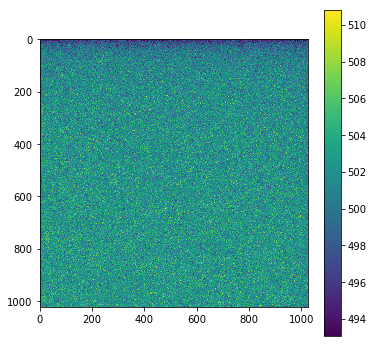

In [7]:
plt.figure(figsize=(6, 6))
plt.imshow(master_bias, vmax=bias_mean + 4*bias_std, vmin=bias_mean - 4*bias_std)
plt.colorbar()

In [8]:
flat_list = []
for flatfile in flatfiles:
    f = fits.open(flatfile)[0]
    n = f.data.shape[0]
    for x in [ccdproc.CCDData(data=f.data[i], meta=f.header, unit='adu') for i in range(n)]:
        flat_list.append(x)


In [9]:
for i in range(len(flat_list)):
    flat_list[i] = ccdproc.subtract_bias(flat_list[i], master_bias)

In [10]:
master_flat = ccdproc.combine(flat_list, method='median', scale=lambda x: 1./np.median(x))

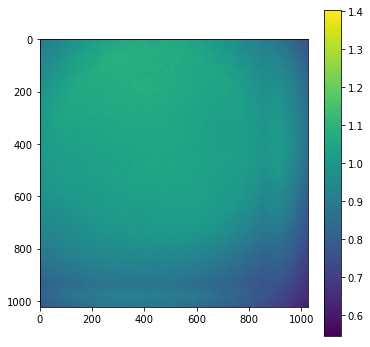

In [11]:
f_min, f_max, f_mean, f_std = imstats(np.asarray(master_flat))
plt.figure(figsize=(6, 6))
plt.imshow(master_flat, vmin=f_mean-5*f_std, vmax=f_mean+5*f_std)
plt.colorbar()

In [131]:
science_list = []
time = np.array([])
for sciencefile in sciencefiles:
    f = fits.open(sciencefile)[0]
    n = f.data.shape[0]
    for x in [ccdproc.CCDData(data=f.data[i], meta=f.header, unit='adu') for i in range(n)]:
        science_list.append(x) 
        t = Time(f.header['FRAME'])
    time = np.r_[time,np.linspace(t.mjd,t.mjd+(f.header['KCT']/86400.),num=f.header['NUMKIN'])]


In [13]:
for i in range(len(science_list)):
    science_list[i] = ccdproc.subtract_bias(science_list[i], master_bias)

In [14]:
for i in range(len(science_list)):
    science_list[i] = ccdproc.flat_correct(science_list[i], master_flat)

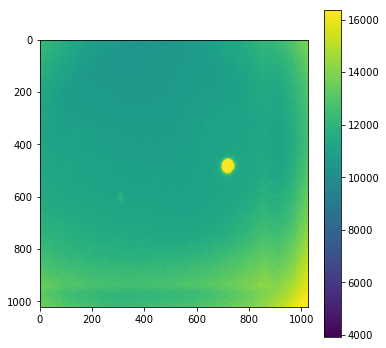

In [15]:
f_min, f_max, f_mean, f_std = imstats(science_list[4].data)

plt.figure(figsize=(6, 6))
plt.imshow(science_list[4],vmin=f_mean-5*f_std, vmax=f_mean+3*f_std)
plt.colorbar()

In [16]:
from photutils import DAOStarFinder
from astropy.stats import mad_std

In [17]:
image = science_list[50].data

In [18]:
bkg_sigma = mad_std(image)    

In [23]:
daofind = DAOStarFinder(fwhm=8., threshold=5.*bkg_sigma)

In [24]:
sources = daofind(image)

In [25]:
np.min(sources['mag'])

-2.5364503786786634

In [40]:
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
positions = (sources['xcentroid'], sources['ycentroid'])  
apertures = CircularAperture(positions, r=8.)    
phot_table = aperture_photometry(image, apertures) 
print(phot_table)  

 id      xcenter            ycenter        aperture_sum
           pix                pix                      
--- ------------------ ------------------ -------------
  1 3.5739106207193596  3.632411212985396 1564764.26424
  2 1019.4332682980805 3.6196664712103646 1805855.18718
  3  717.5108759262296 488.36827145622897 14732729.7272
  4 3.5669401520932906 1019.4164432575113 1736663.72102
  5 1019.4120225035588 1019.4074980447746 2169987.02691


/Users/tom/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


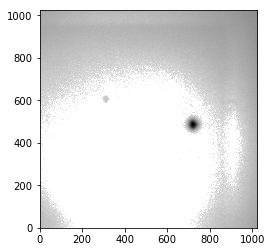

In [27]:
plt.imshow((image - np.median(image))**0.3, cmap='gray_r', origin='lower')
# apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [108]:
a = np.array([])
b = np.array([])
c = np.array([])
bg = np.array([])
image = science_list[100].data
bkg_sigma = mad_std(image)
daofind = DAOStarFinder(fwhm=8., threshold=5.*bkg_sigma)
sources = daofind(image)
idx = np.argmax(sources['flux'])
positions = (sources['xcentroid'], sources['ycentroid'])
a1 = CircularAperture(positions, r=16)
a2 = CircularAperture(positions, r=20)
a3 = CircularAperture(positions, r=30)
annulus_apertures = CircularAnnulus(positions, r_in=35., r_out=45)  
apers = [a1, a2, a3, annulus_apertures]
for d in tqdm.tqdm(range(len(science_list[:]))):
    image = science_list[d].data
    phot_table = aperture_photometry(image, apers)
    a = np.r_[a,phot_table[3]['aperture_sum_0']]
    b = np.r_[b, phot_table[3]['aperture_sum_1']]
    c = np.r_[c, phot_table[3]['aperture_sum_2']]
    bg = np.r_[bg, phot_table[3]['aperture_sum_3']]

100%|██████████| 230/230 [00:02<00:00, 102.02it/s]


In [109]:
sources['id' == 3]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,3.57391062072,3.63241121299,0.308171703878,-0.11595087951,0.00580258630109,121.0,0.0,11823.4967064,7.22080866302,-2.14646459303


id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,aperture_sum_2,aperture_sum_3
,pix,pix,,,,
int64,float64,float64,float64,float64,float64,float64
1,3.5739106207193596,3.632411212985396,4194935.70921,5959664.22866,11670467.5346,8443704.35941
2,1019.4332682980805,3.6196664712103646,4811430.2096,6815220.85283,13282803.4464,9525385.71637
3,717.5108759262296,488.36827145622897,43520507.8517,56261663.644,79834768.6437,28284915.8804
4,3.5669401520932906,1019.4164432575113,4621506.51663,6545300.52877,12764281.7929,9193819.24161
5,1019.4120225035588,1019.4074980447746,5771308.32552,8163225.23704,15841354.2319,11223741.8532


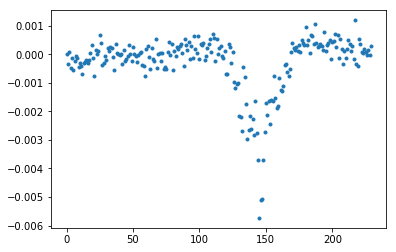

In [142]:
plt.plot((a/bg) / np.median(a/bg) - 1.0, '.', alpha=1.0)
# plt.plot((b-bg) / np.median(b-bg) - 1.0, '.', alpha=0.1)
# plt.plot((c-bg) / np.median(c-bg) - 1.0, '.', alpha=0.1)
# plt.plot((bg) / np.median(bg) - 1.0, '.')
phot_table

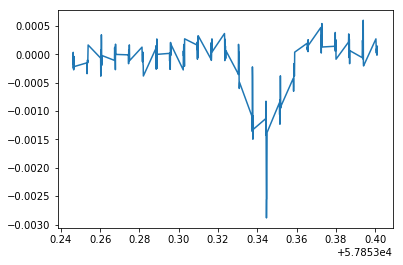

In [132]:
plt.plot(time, (a/bg) -np.mean(a[40:100]/bg[40:100]))

In [133]:
print(np.mean(a[40:100]) / np.std(a[40:100]))
print(np.mean(b[40:100]) / np.std(b[40:100]))
print(np.mean(c[40:100]) / np.std(c[40:100]))
print(np.mean(bg[40:100]) / np.std(bg[40:100]))

427.192398715
422.410703065
415.772471098
404.53306677


In [49]:
# plt.figure(figsize=(16, 16))
# plt.imshow(science_list[200][440:490,315:345])

In [50]:
plt.figure(figsize=(6, 6))

plt.imshow((((medim)- np.median(medim)) / np.median(medim)), vmax)
plt.colorbar()

NameError: name 'medim' is not defined

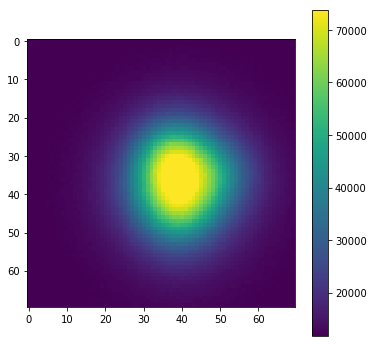

In [92]:
f_min, f_max, f_mean, f_std = imstats(science_list[4].data)

plt.figure(figsize=(6, 6))
plt.imshow(science_list[120][453:523,682:752],vmin=f_mean-0*f_std, vmax=f_mean+40*f_std)
plt.colorbar()

In [116]:
f.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                 1024 / length of data axis 1                          
NAXIS2  =                 1024 / length of data axis 2                          
NAXIS3  =                   10 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =           2147483648 / offset data range to that of unsigned long     
BSCALE  =                    1 / default scaling factor                         
HEAD    = 'DU888_BV'           / Head model                                     
ACQMODE = 'Frame Transfer'  

In [120]:
t = Time(f.header['FRAME'])
t.mjd

57853.40039351852

In [126]:
f.

array([[[11656, 11666, 11805, ..., 11539, 11617, 11488],
        [11642, 11725, 11639, ..., 11581, 11565, 11383],
        [11587, 11692, 11701, ..., 11492, 11651, 11445],
        ..., 
        [11258, 11329, 11347, ..., 11175, 11147, 11125],
        [11274, 11296, 11319, ..., 11174, 11293, 11096],
        [11281, 11302, 11356, ..., 11194, 11134, 11142]],

       [[11629, 11658, 11749, ..., 11514, 11620, 11523],
        [11574, 11626, 11608, ..., 11588, 11589, 11505],
        [11544, 11638, 11592, ..., 11518, 11545, 11453],
        ..., 
        [11281, 11352, 11396, ..., 11206, 11130, 11179],
        [11271, 11192, 11357, ..., 11280, 11167, 11112],
        [11236, 11296, 11315, ..., 11132, 11212, 11094]],

       [[11600, 11660, 11663, ..., 11496, 11492, 11342],
        [11585, 11648, 11756, ..., 11512, 11467, 11361],
        [11461, 11592, 11644, ..., 11547, 11463, 11390],
        ..., 
        [11148, 11290, 11364, ..., 11186, 11281, 11065],
        [11323, 11321, 11299, ..., 11195, 

In [136]:
t.mjd f[]

57853.40039351852

In [137]:
np.linspace(t.mjd,t.mjd+(f.header['KCT']/86400.),num=f.header['NUMKIN'])

array([ 57853.40039352,  57853.4004708 ,  57853.40054807,  57853.40062535,
        57853.40070262,  57853.4007799 ,  57853.40085718,  57853.40093445,
        57853.40101173,  57853.40108901])

In [139]:
f.header['KCT']/86400.

0.0006954894675925927

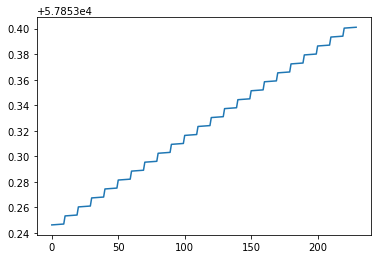

In [141]:
plt.plot(time)